# Notebook to make Fig. 12

In [1]:
# Import necessary packages & set-up plotting aesthetics
import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde
import json

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from fig_helper_functions import *

style.use('plotting.mplstyle')

import sys
sys.path.append('./../Code/PopulationInference')
from posterior_helper_functions import mu_sigma2_to_a_b, calculate_betaDistribution, calculate_Double_Gaussian

import seaborn as sns
sns.set_palette('colorblind')

### Load data

Underlying populations

In [2]:
f_root = '../Data/InjectedPopulationParameters/' 
pop1 = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'underlying_population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

# Set up grids to evaluate KDEs on
chi_grid = np.linspace(0,1,500)
cost_grid =  np.linspace(-1,1,500)

# Dict in which to store KDEs
kde_dict = {}

# Cycle through populations
for pop,pop_key in zip([pop1, pop2, pop3], ['pop 1', 'pop 2', 'pop 3']):
    
    # Use function in fig_helper_functions
    kde_dict[pop_key] = get_KDE_dict_spins(pop)

`emcee` hierarchical inference samples

In [3]:
# For loading files
models = ['betaPlusDoubleGaussianJustChi', 'betaPlusDoubleGaussianJustCosTheta']
pops = ['1', '2', '3']
nevents = ['70'] 
date = '102723'

# Make Dict
data_dict = {}

# Cycle through the different runs
for model in models:
    data_dict_model = {}
    for pop in pops: 
        
        print(model, pop)
        
        data_dir = f'../Data/PopulationInferenceOutput/{model}/'
        name = data_dir+f"{date}_{model}_pop{pop}_70events.json"
        
        with open(name, 'r') as f:
            data = json.load(f)
            
        data_dict_model[pop] = data
            
    data_dict[model] = data_dict_model

betaPlusDoubleGaussianJustChi 1
betaPlusDoubleGaussianJustChi 2
betaPlusDoubleGaussianJustChi 3
betaPlusDoubleGaussianJustCosTheta 1
betaPlusDoubleGaussianJustCosTheta 2
betaPlusDoubleGaussianJustCosTheta 3


In [4]:
data_dict['betaPlusDoubleGaussianJustChi'].keys()

dict_keys(['1', '2', '3'])

### Generate traces

In [5]:
# Make dict 
traces_dict = {}

# Choose a number of traces to draw
nTracesMax = 1000

# Cycle through populations
traces_dict = {}
for pop in pops: 
    
    # Just chi dist
    data = data_dict['betaPlusDoubleGaussianJustChi'][pop]

    # Instantiate an array to hold a collection of traces
    nTraces = min(nTracesMax, len(data['mu_chi']['processed']))
    p_chi = np.zeros((nTraces,chi_grid.size))
    
    # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
    random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
    for i,ind in enumerate(random_indices):

        print(i, end='\r')

        mu_chi = data['mu_chi']['processed'][ind]
        sigma_chi = data['sigma_chi']['processed'][ind]

        # calculate gaussian distribution for chi
        a,b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
        p_chi[i,:] = calculate_betaDistribution(chi_grid, a, b)
      
    # Just cost dist
    data = data_dict['betaPlusDoubleGaussianJustCosTheta'][pop]

    # Instantiate an array to hold a collection of traces
    nTraces = min(nTracesMax, len(data['mu1_cost']['processed']))
    p_cost = np.zeros((nTraces,cost_grid.size))
    
    # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
    random_indices = np.random.choice(np.arange(len(data['mu1_cost']['processed'])), size=nTraces,replace=False)
    for i,ind in enumerate(random_indices):
        
        mu1_cost = data['mu1_cost']['processed'][ind]
        sigma1_cost = data['sigma1_cost']['processed'][ind]
        mu2_cost = data['mu2_cost']['processed'][ind]
        sigma2_cost = data['sigma2_cost']['processed'][ind]
        MF_cost = data['MF_cost']['processed'][ind]

        # and gaussian distribution for cos(theta)
        p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)

    # Add to dict 
    traces_dict[pop] = {'p_chi':p_chi, 'p_cost':p_cost} 

### Plot spin distributions for each population

In [11]:
## From Fig 2 for comparison 
with open('pop3_70events_pops.json', 'r') as f:
    fig2_comparison = json.load(f)
    
comparison_kws = dict(color='navy', ls='--')

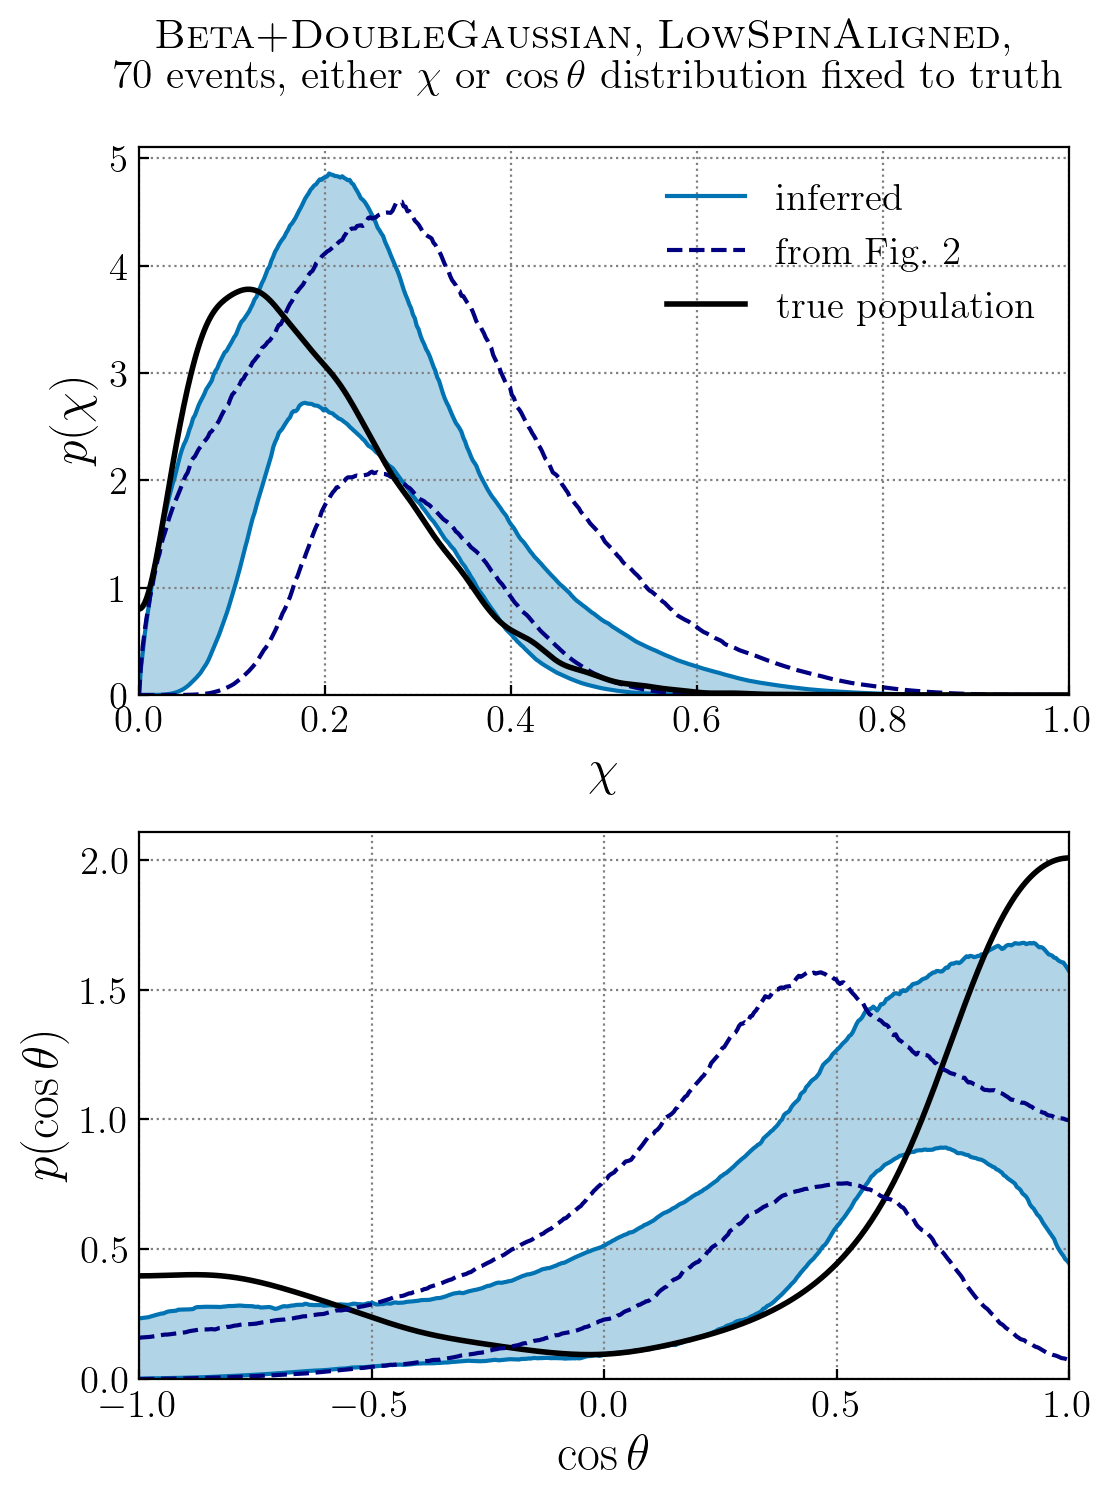

In [20]:
colors = ['#004f7a', 'C1']

fig,axes = plt.subplots(2, 1, figsize=(6, 8))
    
# spin magnitude
p_chi = traces_dict['3']['p_chi']
chi_quants = np.quantile(p_chi, (0.05, 0.95), axis=0)
axes[0].plot(chi_grid, chi_quants[0], color='C0', label=r'inferred')
axes[0].plot(chi_grid, chi_quants[1], color='C0')
axes[0].fill_between(chi_grid, chi_quants[0], y2=chi_quants[1], alpha=0.3)

axes[0].plot(chi_grid, fig2_comparison['chi'][0], **comparison_kws, label='from Fig.~2')
axes[0].plot(chi_grid, fig2_comparison['chi'][1], **comparison_kws)
axes[0].plot(chi_grid, kde_dict[pop_key]['chi'], color='k', lw=2, label='true population')

axes[0].set_xlim(0,1)
axes[0].set_ylim(0,)

axes[0].legend()

# tilt angle
p_cost = traces_dict['3']['p_cost']
cost_quants = np.quantile(p_cost, (0.05, 0.95), axis=0)
axes[1].plot(cost_grid, cost_quants.T, color='C0')
axes[1].fill_between(cost_grid, cost_quants[0], y2=cost_quants[1], alpha=0.3)

axes[1].plot(cost_grid, kde_dict[pop_key]['cost'], color='k', lw=2)
axes[1].plot(cost_grid, np.transpose(fig2_comparison['cost']), **comparison_kws)
axes[1].set_xlim(-1,1)
axes[1].set_ylim(0,)

axes[0].set_xlabel(r'$\chi$')
axes[0].set_ylabel(r'$p(\chi)$')

axes[1].set_xlabel(r'$\cos\theta$')
axes[1].set_ylabel(r'$p(\cos\theta)$')

plt.suptitle(r'$\mathrm{\textsc{Beta+DoubleGaussian}}$, $\mathrm{\textsc{LowSpinAligned}}$, \\70 events, either $\chi$ or $\cos\theta$ distribution fixed to truth', 
             fontsize=15, y=0.96)

plt.subplots_adjust(hspace=0.25)
    
plt.savefig('figure_12.pdf',bbox_inches='tight')
plt.show()